
#Skin Cancer Detection utilizing Deep Learning: Classification of Skin Lesion Images using a Vision Transformer (ViT)


Carolin Flosdorf | Igor Keller | Justin Engelker | Nicolas Mohr

# Setup



## Install and Load Packages

In [ ]:
!pip install kaggle
!pip install split-folders
!pip install --quiet vit-keras
!pip install coremltools
!pip install tensorflow-addons
!pip install vit-keras

In [ ]:
# File and directory operations
import os
from glob import glob
from google.colab import drive

# Data import, manipulation and analysis
import pandas as pd
import numpy as np
import cv2

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Image processing
from PIL import Image

# Machine learning and deep learning frameworks
import keras
import tensorflow as tf
import tensorflow_addons as tfa

# Keras backend
from keras import backend as K

# Keras layers and optimizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import Regularizer

# Metrics and preprocessing from scikit-learn
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model-related callbacks and utilities
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Data augmentation for image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Utility functions for visualization and model evaluation
import itertools
import shutil
import math

# Vision Transformer (ViT) for image classification
from vit_keras import vit
from vit_keras import visualize

# NumPy random seed for reproducibility
np.random.seed(123)


## Set up Connection to Kaggle

In [ ]:
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR']="/content/drive/MyDrive/Kaggle"

Set to inform Kaggle where to find the configuration files containing API credentials, allowing seamless interaction with the Kaggle platform for downloading the data.

In [ ]:
# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!ls
!unzip skin-cancer-mnist-ham10000.zip

In [ ]:
os.listdir('/content')

# Data Preparation

In [7]:
# Create a base directory to organize data into training, validation, and test sets
base_dir = 'base_dir'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# Create new folders for each skin cancer type inside training directory
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# Create new folders for each skin cancer type inside validation directory
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

# Create new folders for each skin cancer type inside test directory
nv = os.path.join(test_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(test_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(test_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(test_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(test_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(test_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(test_dir, 'df')
os.mkdir(df)

In [8]:
# Load metadata from a CSV file into a Pandas DataFrame
df = pd.read_csv('../content/HAM10000_metadata.csv')

# Set the base directory for images
base_skin_dir = os.path.join('..', 'content')

# Create a dictionary mapping image IDs to their file paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Define a dictionary mapping lesion types to their corresponding descriptions
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Creating New Columns for better readability
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../content/ham10000_images_part_1/ISIC_0027419...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../content/ham10000_images_part_1/ISIC_0025030...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../content/ham10000_images_part_1/ISIC_0026769...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../content/ham10000_images_part_1/ISIC_0025661...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../content/ham10000_images_part_2/ISIC_0031633...,Benign keratosis-like lesions,2


In [ ]:
# Map the 'path' column to a new 'image' column, converting image files to NumPy arrays
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x)))

# Visualize sample images from different lesion types
n_samples = 5

# Create a subplot grid for displaying sample images
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))

# Iterate over subplot grid and lesion types in the DataFrame
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Save the figure with sample images to a file
fig.savefig('category_samples.png', dpi=500)

## Data Cleansing

In [10]:
# Check for missing values
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
image             0
dtype: int64

In [11]:
# Drop missing value and 'unkown' gender
df.dropna(inplace=True)
df.isna().sum().sum()

df.drop(df[df['sex'] == 'unknown'].index, inplace=True)

# Exploratory Data Analysis

In [12]:
# Display summary and descriptive statistics
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9948 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      9948 non-null   object 
 1   image_id       9948 non-null   object 
 2   dx             9948 non-null   object 
 3   dx_type        9948 non-null   object 
 4   age            9948 non-null   float64
 5   sex            9948 non-null   object 
 6   localization   9948 non-null   object 
 7   path           9948 non-null   object 
 8   cell_type      9948 non-null   object 
 9   cell_type_idx  9948 non-null   int8   
 10  image          9948 non-null   object 
dtypes: float64(1), int8(1), object(9)
memory usage: 864.6+ KB


,age,cell_type_idx
count,9948.000000,9948.000000
mean,51.878267,3.623241
std,16.957802,1.211350
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


In [13]:
# Checking for skin cancer among babies (Age = 0)
baby = df[df['age'] == 0]
len(baby)

37

37 Observations with age = 0. It will not be removed since babies can have skin cancer too.

In [14]:
# Age differences among genders
df.groupby('sex')['age'].mean()

sex
female    48.711522
male      54.545370
Name: age, dtype: float64

Males are older than females on average (might explain higher cancer rate)

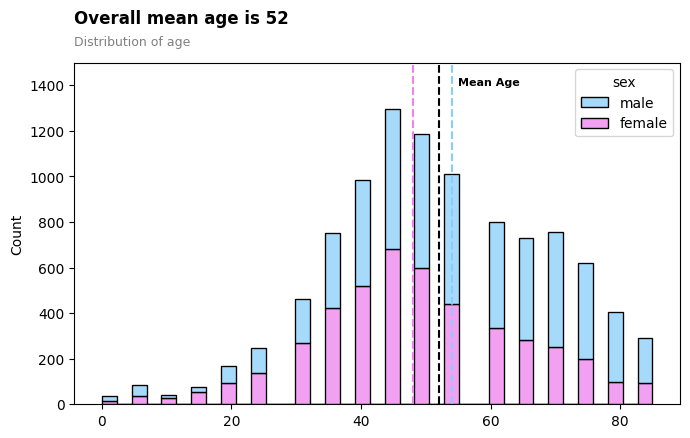

In [15]:
# Plot skin cancer distribution based on age and gender
fig,axes = plt.subplots(figsize=(7,5))
colors = {'male': 'lightskyblue', 'female': 'violet'}
ax = sns.histplot(data=df, x='age', hue='sex', multiple='stack', palette=colors)
plt.title('Overall mean age is 52', y=1.09, fontweight='bold', loc='left', fontsize=12)
plt.suptitle('Distribution of age', color='grey', y=1.08, fontsize=9, transform=ax.transAxes, ha='left', x=0)
fig.tight_layout()
plt.ylim(0, 1500)
plt.ylabel('Count')
plt.xlabel('')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
ax.set_facecolor('#FFFFFF')
ax.axvline(x=52, color='black', linestyle='dashed')
ax.axvline(x=54, color='lightskyblue', linestyle='dashed')
ax.axvline(x=48, color='violet', linestyle='dashed')
ax.annotate('Mean Age', xy=(52, 1450), xytext=(55, 1400), fontsize = 8, color='black', fontweight='bold')

plt.show()

Gender Differences

It seems like men are more often affected than women. However, this might only be true for the dataset

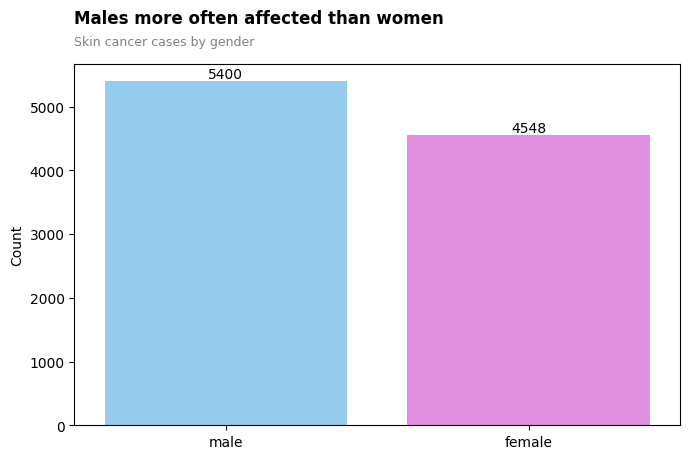

In [16]:
# Plot skin cancer occurrence based on gender
fig, axes = plt.subplots(figsize=(7,5))
colors = {'male': 'lightskyblue', 'female': 'violet'}
ax = sns.countplot(x='sex', data=df, palette = colors, hue='sex')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Males more often affected than women', y=1.09,fontweight='bold', loc='left', fontsize=12)
plt.suptitle('Skin cancer cases by gender', color='grey', y=1.08, fontsize=9, transform=ax.transAxes, ha='left', x=0)
plt.xlabel('')
plt.ylabel('Count')
fig.tight_layout()
plt.rcParams['figure.facecolor'] = '#FFFFFF'
ax.set_facecolor('#FFFFFF')

plt.show()

Frequency of Skin Cancer Types

The data does not necessarily reflect the distribution of the population. While it makes sense to have most observations being benign moles (Melanocytic Nevi), the most dangerous type of skin cancer (Melanoma) is already the second most common. However, Basal Cell Carcinoma is much more common in the real world.

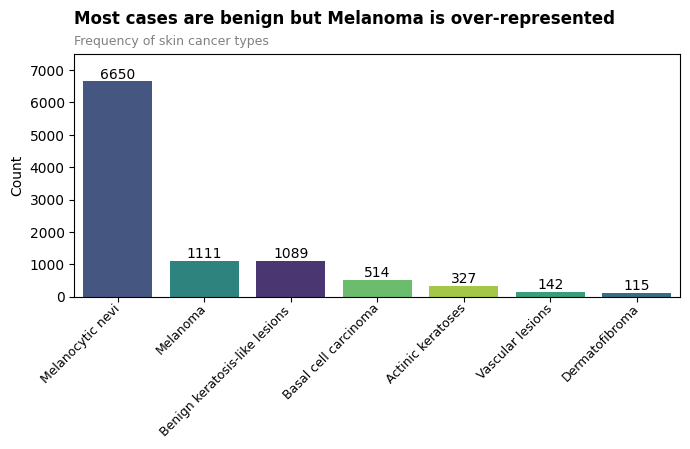

In [17]:
# Plot skin cancer type occurrence
fig,axes = plt.subplots(figsize=(7,5))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'viridis',hue='cell_type')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Most cases are benign but Melanoma is over-represented', y=1.09,fontweight='bold', loc='left', fontsize=12)
plt.suptitle('Frequency of skin cancer types', color='grey', y=1.08, fontsize=9, transform=ax.transAxes, ha='left', x=0)
plt.ylabel('Count')
plt.setp(ax.get_xticklabels(),rotation= 45, ha = 'right', va = 'center', rotation_mode = 'anchor')
ax.tick_params(axis='x',labelsize=9)
plt.xlabel('')
plt.xticks(rotation=45)
fig.tight_layout()
plt.ylim(0, 7500)
plt.rcParams['figure.facecolor'] = '#FFFFFF'
ax.set_facecolor('#FFFFFF')

plt.show()

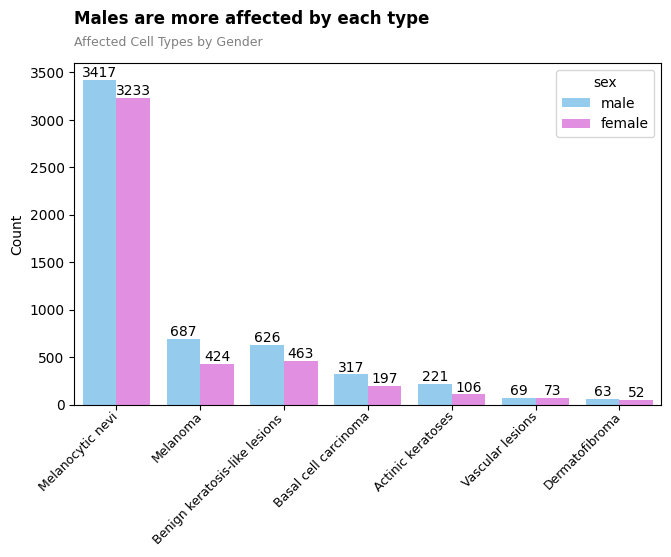

In [18]:
# Plot skin cancer type occurrence based on gender
fig,axes = plt.subplots(figsize=(7,5))
colors = {'male': 'lightskyblue', 'female': 'violet'}
ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = colors)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Males are more affected by each type', y=1.09,fontweight='bold', loc='left', fontsize=12)
plt.suptitle('Affected Cell Types by Gender', color='grey', y=1.08, fontsize=9, transform=ax.transAxes, ha='left', x=0)
fig.tight_layout()
plt.ylim(0, 3600)
plt.setp(ax.get_xticklabels(),rotation= 45, ha = 'right', va = 'center', rotation_mode = 'anchor')
ax.tick_params(axis='x',labelsize=9)
plt.ylabel('Count')
plt.xlabel('')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
ax.set_facecolor('#FFFFFF')
plt.xticks(rotation=45)

plt.show()

In [19]:
# Since males are more frequent in the data, we check their relative frequency per cancer type
df_sub = df.groupby(['sex', 'cell_type'])['dx'].count().reset_index()
df_sub['weighted'] = df_sub.apply(lambda row: row['dx'] / 5400 if row['sex'] == 'male'
                                  else row['dx'] / 4548, axis=1)

df_sub

,sex,cell_type,dx,weighted
0,female,Actinic keratoses,106,0.023307
1,female,Basal cell carcinoma,197,0.043316
2,female,Benign keratosis-like lesions,463,0.101803
3,female,Dermatofibroma,52,0.011434
4,female,Melanocytic nevi,3233,0.710862
5,female,Melanoma,424,0.093228
6,female,Vascular lesions,73,0.016051
7,male,Actinic keratoses,221,0.040926
8,male,Basal cell carcinoma,317,0.058704
9,male,Benign keratosis-like lesions,626,0.115926


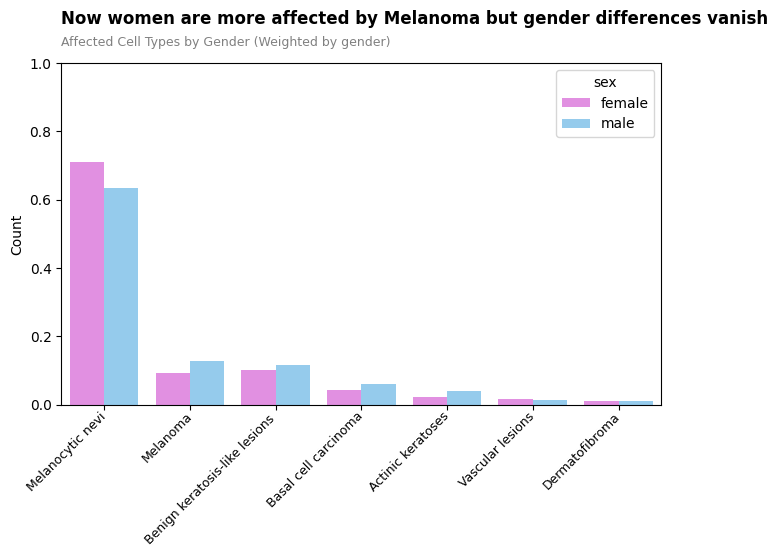

In [20]:
# Plot relative skin cancer type occurrence based on gender
fig,axes = plt.subplots(figsize=(7,5))
colors = {'male': 'lightskyblue', 'female': 'violet'}
ax = sns.barplot(x='cell_type', y='weighted', hue='sex', data=df_sub, order = df['cell_type'].value_counts().index, palette = colors)
plt.title('Now women are more affected by Melanoma but gender differences vanish', y=1.09,fontweight='bold', loc='left', fontsize=12)
plt.suptitle('Affected Cell Types by Gender (Weighted by gender)', color='grey', y=1.08, fontsize=9, transform=ax.transAxes, ha='left', x=0)
fig.tight_layout()
plt.ylim(0, 1)
plt.setp(ax.get_xticklabels(),rotation= 45, ha = 'right', va = 'center', rotation_mode = 'anchor')
ax.tick_params(axis='x',labelsize=9)
plt.ylabel('Count')
plt.xlabel('')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
ax.set_facecolor('#FFFFFF')
plt.xticks(rotation=45)

plt.show()

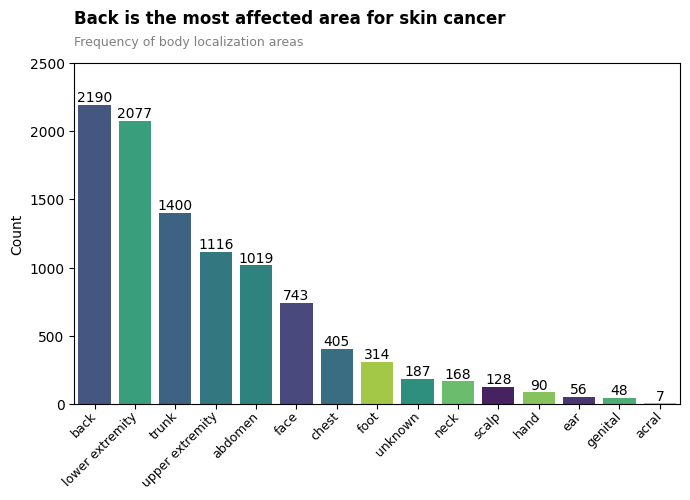

In [21]:
# Plot areas where skin cancer occurs
fig,axes = plt.subplots(figsize=(7,5))
ax = sns.countplot(x='localization',data=df, hue='localization',order = df['localization'].value_counts().index, palette = 'viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Back is the most affected area for skin cancer', y=1.09,fontweight='bold', loc='left', fontsize=12)
plt.suptitle('Frequency of body localization areas', color='grey', y=1.08, fontsize=9, transform=ax.transAxes, ha='left', x=0)
fig.tight_layout()
plt.ylim(0, 2500)
plt.setp(ax.get_xticklabels(),rotation= 45, ha = 'right', va = 'center', rotation_mode = 'anchor')
ax.tick_params(axis='x',labelsize=9)
plt.ylabel('Count')
plt.xlabel('')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
ax.set_facecolor('#FFFFFF')
plt.xticks(rotation=45)

plt.show()

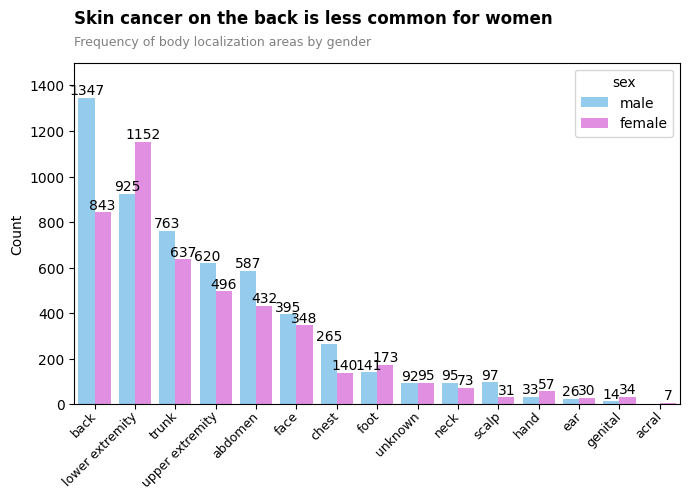

In [22]:
# Plot areas where skin cancer occurs given gender
fig,axes = plt.subplots(figsize=(7,5))
colors = {'male': 'lightskyblue', 'female': 'violet'}
ax = sns.countplot(x='localization', hue='sex', data=df, order = df['localization'].value_counts().index, palette = colors)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Skin cancer on the back is less common for women', y=1.09,fontweight='bold', loc='left', fontsize=12)
plt.suptitle('Frequency of body localization areas by gender', color='grey', y=1.08, fontsize=9, transform=ax.transAxes, ha='left', x=0)
fig.tight_layout()
plt.ylim(0, 1500)
plt.setp(ax.get_xticklabels(),rotation= 45, ha = 'right', va = 'center', rotation_mode = 'anchor')
ax.tick_params(axis='x',labelsize=9)
plt.ylabel('Count')
plt.xlabel('')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
ax.set_facecolor('#FFFFFF')
plt.xticks(rotation=45)

plt.show()

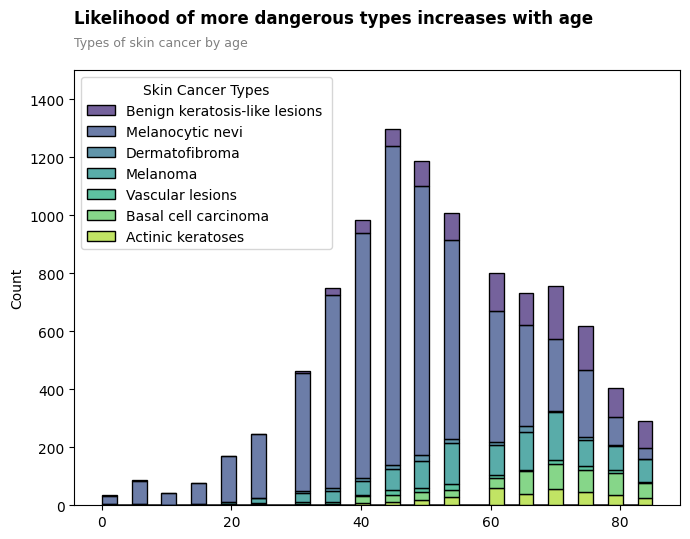

In [23]:
# Plot distribution of skin cancer type based on age
fig,axes = plt.subplots(figsize=(7,6))
ax = sns.histplot(data=df, x='age', hue='cell_type', multiple='stack', palette='viridis')
plt.title('Likelihood of more dangerous types increases with age', y=1.09, fontweight='bold', loc='left', fontsize=12)
plt.suptitle('Types of skin cancer by age', color='grey', y=1.08, fontsize=9, transform=ax.transAxes, ha='left', x=0)
fig.tight_layout()
plt.ylim(0, 1500)
plt.ylabel('Count')
plt.xlabel('')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
ax.set_facecolor('#FFFFFF')
sns.move_legend(ax, title='Skin Cancer Types', loc='best')

plt.show()

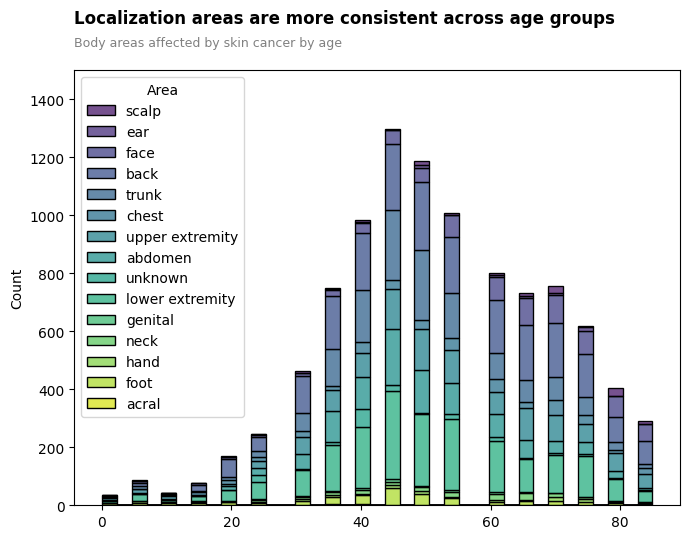

In [24]:
# Plot distribution of where the skin cancer occurs based on age
fig,axes = plt.subplots(figsize=(7,6))
ax = sns.histplot(data=df, x='age', hue='localization', multiple='stack', palette='viridis')
plt.title('Localization areas are more consistent across age groups', y=1.09, fontweight='bold', loc='left', fontsize=12)
plt.suptitle('Body areas affected by skin cancer by age', color='grey', y=1.08, fontsize=9, transform=ax.transAxes, ha='left', x=0)
fig.tight_layout()
plt.ylim(0, 1500)
plt.ylabel('Count')
plt.xlabel('')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
ax.set_facecolor('#FFFFFF')
sns.move_legend(ax, title='Area', loc='best')

plt.show()

# Data Splitting

In [25]:
# Cound the number of images associated with a lesion_id
df_ = df.groupby('lesion_id').count()

# Filter out lesion_id with 1 image
df_ = df_[df_['image_id'] == 1]

# Reset the index of the resulting DataFrame for better representation and display it
df_.reset_index(inplace=True)
df_.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1


In [26]:
# Define a function 'identify_duplicates' that checks if a given lesion_id has duplicates
def identify_duplicates(x):

    unique_list = list(df_['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# Create a new column 'duplicates' that is a copy of the lesion_id column in the DataFrame
df['duplicates'] = df['lesion_id']

# Apply the 'identify_duplicates' function to the 'duplicates' column to label each lesion_id
df['duplicates'] = df['duplicates'].apply(identify_duplicates)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../content/ham10000_images_part_1/ISIC_0027419...,Benign keratosis-like lesions,2,"[[[188, 147, 191], [186, 148, 189], [187, 150,...",has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../content/ham10000_images_part_1/ISIC_0025030...,Benign keratosis-like lesions,2,"[[[25, 15, 23], [25, 14, 22], [25, 14, 22], [2...",has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../content/ham10000_images_part_1/ISIC_0026769...,Benign keratosis-like lesions,2,"[[[186, 128, 140], [188, 128, 136], [183, 126,...",has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../content/ham10000_images_part_1/ISIC_0025661...,Benign keratosis-like lesions,2,"[[[24, 9, 16], [22, 11, 15], [23, 11, 15], [26...",has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../content/ham10000_images_part_2/ISIC_0031633...,Benign keratosis-like lesions,2,"[[[122, 80, 102], [124, 82, 104], [127, 83, 10...",has_duplicates


In [27]:
# Count the duplicates
df['duplicates'].value_counts()

no_duplicates     5467
has_duplicates    4481
Name: duplicates, dtype: int64

In [28]:
# Filter images without duplicates and print the corresponding DataFrame
df_ = df[df['duplicates'] == 'no_duplicates']

print(df_.shape)
df_.head()

(5467, 12)


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image,duplicates
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,../content/ham10000_images_part_1/ISIC_0025276...,Benign keratosis-like lesions,2,"[[[22, 13, 16], [22, 11, 15], [22, 11, 15], [2...",no_duplicates
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,../content/ham10000_images_part_2/ISIC_0031326...,Benign keratosis-like lesions,2,"[[[202, 160, 180], [198, 159, 178], [197, 160,...",no_duplicates
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,../content/ham10000_images_part_2/ISIC_0032343...,Benign keratosis-like lesions,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",no_duplicates
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,../content/ham10000_images_part_1/ISIC_0024981...,Benign keratosis-like lesions,2,"[[[204, 209, 213], [205, 204, 209], [205, 203,...",no_duplicates
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,../content/ham10000_images_part_1/ISIC_0027815...,Benign keratosis-like lesions,2,"[[[0, 0, 0], [0, 0, 0], [1, 1, 1], [6, 4, 7], ...",no_duplicates


We have 9,948 data observations, and our goal is to reserve 10% for testing and validation. This means that 18% (995 out of 5,467) of the images from the "df_" data frame with the unique images will be reserved for the test split and 22% from the remaining unique images in "df_placeholder" data frame.

In [29]:
# Create a target variable 'y' representing the lesion types
y = df_['dx']

# Split into training and testing sets as well as training and validation sets, maintaining the distribution of lesion types
df_placeholder_, df_test = train_test_split(df_, test_size=0.18, random_state=101, stratify=y)
_, df_val = train_test_split(df_placeholder_, test_size=0.22, random_state=101, stratify=df_placeholder_['dx'])

# Display the shapes of the testing and validation sets
print(df_test.shape)
print(df_val.shape)


(985, 12)
(987, 12)


In [30]:
# Display the counts of lesion types in the validation and testing set
print(df_val['dx'].value_counts())
print(df_test['dx'].value_counts())

nv       790
bkl       78
mel       42
bcc       32
akiec     27
vasc      11
df         7
Name: dx, dtype: int64
nv       788
bkl       78
mel       41
bcc       32
akiec     27
vasc      12
df         7
Name: dx, dtype: int64


In [31]:
# Define a function 'identify_data_split' to determine whether an image belongs to the validation, testing, or training set
def identify_data_split(x, df_val, df_test):
    # Create a list of all the image_id's in the val and test sets
    val_list = list(df_val['image_id'])
    test_list = list(df_test['image_id'])

    if str(x) in val_list:
        return 'val'
    elif str(x) in test_list:
        return 'test'
    else:
        return 'train'

# Create a new column 'train_or_val_test' as a copy of the 'image_id' column
df['train_or_val_test'] = df['image_id']

# Apply the 'identify_data_split' function to the 'train_or_val_test' column
df['train_or_val_test'] = df['train_or_val_test'].apply(lambda x: identify_data_split(x, df_val, df_test))

# Filter out rows labeled as part of the training set
df_train = df[df['train_or_val_test'] == 'train']

# Print length of every DataFrame
print(len(df_train))
print(len(df_val))
print(len(df_test))

7976
987
985


In [32]:
# Display the counts of lesion types in the training, validation and testing set
df_train['dx'].value_counts()
df_val['dx'].value_counts()
df_test['dx'].value_counts()

nv       788
bkl       78
mel       41
bcc       32
akiec     27
vasc      12
df         7
Name: dx, dtype: int64

In [33]:
# Set the 'image_id' column as the index of the DataFrame 'df'
df.set_index('image_id', inplace=True)

In [34]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/content/ham10000_images_part_1')
folder_2 = os.listdir('/content/ham10000_images_part_2')

# Get a list of training, validation and test images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])


# Transfer the training images
for image in train_list:

    fname = image + '.jpg'
    label = df.loc[image,'dx']

    if fname in folder_1:
        # Source path to image
        src = os.path.join('/content/ham10000_images_part_1', fname)
        # Destination path to image
        dst = os.path.join(train_dir, label, fname)
        # Copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # Source path to image
        src = os.path.join('/content/ham10000_images_part_2', fname)
        # Destination path to image
        dst = os.path.join(train_dir, label, fname)
        # Copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the validation images
for image in val_list:

    fname = image + '.jpg'
    label = df.loc[image,'dx']

    if fname in folder_1:
        # Source path to image
        src = os.path.join('/content/ham10000_images_part_1', fname)
        # Destination path to image
        dst = os.path.join(val_dir, label, fname)
        # Copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # Source path to image
        src = os.path.join('/content/ham10000_images_part_2', fname)
        # Destination path to image
        dst = os.path.join(val_dir, label, fname)
        # Copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the test images
for image in test_list:

    fname = image + '.jpg'
    label = df.loc[image,'dx']

    if fname in folder_1:
        # Source path to image
        src = os.path.join('/content/ham10000_images_part_1', fname)
        # Destination path to image
        dst = os.path.join(test_dir, label, fname)
        # Copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # Source path to image
        src = os.path.join('/content/ham10000_images_part_2', fname)
        # Destination path to image
        dst = os.path.join(test_dir, label, fname)
        # Copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [35]:
# Check the number of images of each skin cancer type in training set
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5072
1028
933
450
273
119
101


In [36]:
# Check the number of images of each skin cancer type in validation set
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

790
42
78
32
27
11
7


In [37]:
# Check the number of images of each skin cancer type in testing set
print(len(os.listdir('base_dir/test_dir/nv')))
print(len(os.listdir('base_dir/test_dir/mel')))
print(len(os.listdir('base_dir/test_dir/bkl')))
print(len(os.listdir('base_dir/test_dir/bcc')))
print(len(os.listdir('base_dir/test_dir/akiec')))
print(len(os.listdir('base_dir/test_dir/vasc')))
print(len(os.listdir('base_dir/test_dir/df')))

788
41
78
32
27
12
7


# Data Augmentation

In [38]:
# List of classes, note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

# Loop through each class
for item in class_list:

    # Create an 'aug_dir' directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    # Create a subdirectory 'img_dir' inside 'aug_dir'
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Set the current class
    img_class = item

    # Get the list of images in the current class
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy each image from the source directory to the 'img_dir' directory'
    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)


    # Set paths for augmentation and saving augmented images
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Define data augmentation settings using ImageDataGeneratorr
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.75, 1.25),
        shear_range=0.2,
        zoom_range=0.2,
        channel_shift_range=0.1,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0,
        interpolation_order=1,
        dtype=None
    )

    # Set batch size for the augmented data
    batch_size = 50

    # Create a flow of augmented images from the directory
    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)




    # Set the desired total number of augmented images
    num_aug_images_wanted = 6000

    # Calculate the number of batches needed to reach the desired number of images
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # Generate and save augmented images in the specified directory
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)

    # Remove the temporary 'aug_dir' directory
    shutil.rmtree('aug_dir')


Found 1028 images belonging to 1 classes.
Found 933 images belonging to 1 classes.
Found 450 images belonging to 1 classes.
Found 273 images belonging to 1 classes.
Found 119 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


## Visualization of Data Augmentation

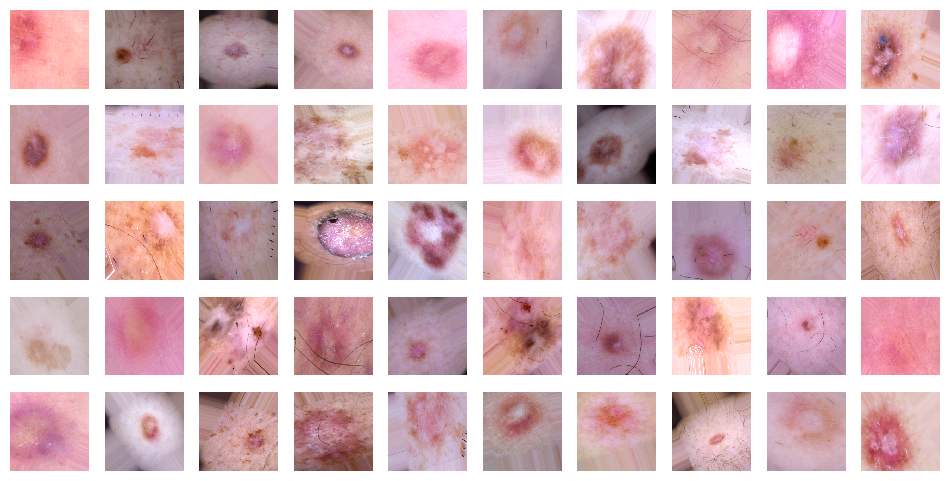

In [39]:
# Function to display the augmented images
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# Plot the augmented images
plots(imgs, titles=None)

In [40]:
# Check the number of images of each skin cancer type in training set after data augmentation
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5072
5940
5948
6000
5510
4810
4090


# Model Building

In [41]:
# Define directory paths for the training, validation, and testing sets
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'base_dir/test_dir'

# Calculate the number of samples in each set
num_train_samples = len(df_train)
num_val_samples = len(df_val)

# Define batch sizes for training and validation
train_batch_size = 16
val_batch_size = 16

# Define the target image size
image_size = 224

# Calculate the number of steps per epoch for training and validation
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [42]:
# Define an ImageDataGenerator with preprocessing function for MobileNet
datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

# Create batches of training, validation, and testing data using flow_from_directory
train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 37370 images belonging to 7 classes.
Found 987 images belonging to 7 classes.
Found 985 images belonging to 7 classes.



## Vision Transformer (ViT) L16



In [ ]:
# Create a Vision Transformer (ViT) model with ViT-L16 architecture using the 'vit' library
vit_model_l16 = vit.vit_l16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 7)

# Without the argument: weights = "imagenet21k", we are using imagenet21k+imagenet2012 because of the pretrained argument

In [44]:
# Create a Sequential model 'model_l16' using ViT-L16 as the base
model_l16 = tf.keras.Sequential([
        vit_model_l16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(28, activation = tf.keras.activations.relu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2), # Dropout layer with 20% Dropout rate
        tf.keras.layers.Dense(7, 'softmax')
    ],
    name = 'Vision_Transformer_L16')

# Display model summary
model_l16.summary()

Model: "Vision_Transformer_L16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l16 (Functional)        (None, 1024)              303301632 
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 28)                28700     
                                                                 
 batch_normalization_1 (Bat  (None, 28)                112       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 28)     

In [45]:
# Compile the ViT-L16 model
model_l16.compile(
    optimizer='sgd',                     # Stochastic Gradient Descent optimizer
    loss='categorical_crossentropy',    # Categorical Crossentropy loss function for multi-class classification
    metrics=['accuracy']                 # Monitor accuracy as a metric during training
)

In [46]:
# Define EarlyStopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Define ModelCheckpoint callback to save the best model based on validation accuracy
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model1.hdf5',
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                  mode='max')

# Define ReduceLROnPlateau callback to adjust learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5, initial_lr=0.001)

# Combine the callbacks
callbacks = [early_stopping, checkpointer, reduce_lr]

In [47]:
# Train the ViT-L16 model
history_l16 = model_l16.fit(train_batches, steps_per_epoch=train_steps,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=20,
                              callbacks=callbacks)

Epoch 1/20
499/499 [==============================] - ETA: 0s - loss: 1.1721 - accuracy: 0.5820
Epoch 1: val_accuracy improved from -inf to 0.83688, saving model to model1.hdf5
499/499 [==============================] - 1143s 2s/step - loss: 1.1721 - accuracy: 0.5820 - val_loss: 0.5494 - val_accuracy: 0.8369 - lr: 0.0100
Epoch 2/20
499/499 [==============================] - ETA: 0s - loss: 0.7524 - accuracy: 0.7332
Epoch 2: val_accuracy improved from 0.83688 to 0.90172, saving model to model1.hdf5
499/499 [==============================] - 1081s 2s/step - loss: 0.7524 - accuracy: 0.7332 - val_loss: 0.3434 - val_accuracy: 0.9017 - lr: 0.0100
Epoch 3/20
499/499 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.7892
Epoch 3: val_accuracy improved from 0.90172 to 0.90274, saving model to model1.hdf5
499/499 [==============================] - 1080s 2s/step - loss: 0.6023 - accuracy: 0.7892 - val_loss: 0.3063 - val_accuracy: 0.9027 - lr: 0.0100
Epoch 4/20
499/499 [=====

### Accuracy and Loss

In [48]:
# Extract training history metrics from the history object
accl16 = history_l16.history['accuracy']
val_accl16 = history_l16.history['val_accuracy']
lossl16 = history_l16.history['loss']
val_lossl16 = history_l16.history['val_loss']
epochsl16 = range(len(accl16))

<Figure size 640x480 with 0 Axes>

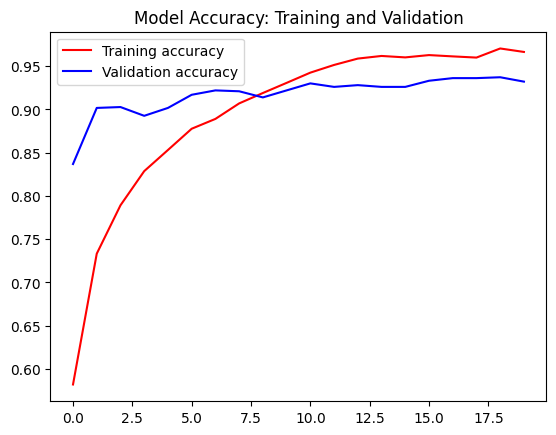

<Figure size 640x480 with 0 Axes>

In [49]:
# Plot training and validation accuracy over epochs
plt.plot(epochsl16, accl16, 'r', label='Training accuracy')
plt.plot(epochsl16, val_accl16, 'b', label='Validation accuracy')
plt.title('Model Accuracy: Training and Validation')
plt.legend(loc=0)
plt.figure()

<Figure size 640x480 with 0 Axes>

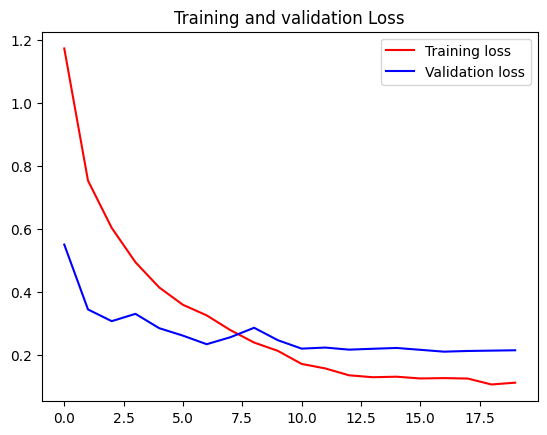

<Figure size 640x480 with 0 Axes>

In [50]:
# Plot training and validation loss over epochs
plt.plot(epochsl16, lossl16, 'r', label='Training loss')
plt.plot(epochsl16, val_lossl16, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

In [51]:
# Evaluate the performance of the ViT-L16 model on the test set
model_test_performace_l16 = model_l16.evaluate(test_batches)

# Print the test accuracy
test_accuracy_l16 = model_test_performace_l16[1]
print(f'Test accuracy: {round(test_accuracy_l16*100, 2)}%')

985/985 [==============================] - 73s 74ms/step - loss: 0.2532 - accuracy: 0.9279
Test accuracy: 92.79%


In [52]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [53]:
# Generate predictions for the test set using the ViT-L16 model
predictions_l16 = model_l16.predict(test_batches, steps=len(test_batches), verbose=1)


985/985 [==============================] - 78s 73ms/step


### Confusion Matrix

Confusion matrix, without normalization
[[ 14   2   5   1   3   2   0]
 [  0  31   0   0   0   1   0]
 [  2   1  54   0   6  15   0]
 [  0   0   0   5   0   2   0]
 [  1   1   3   0  23  12   1]
 [  1   1   5   0   5 776   0]
 [  0   0   0   0   0   1  11]]


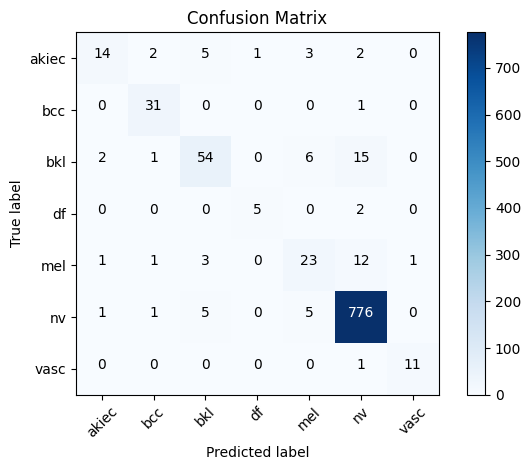

In [54]:
# Get the true class labels for the test set
test_labels = test_batches.classes

# Create a confusion matrix using true class labels and predicted class indices
cml16 = confusion_matrix(test_labels, predictions_l16.argmax(axis=1))

# Define function that prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Define custom class labels for the confusion matrix plot
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

# Plot the confusion matrix
plot_confusion_matrix(cml16, cm_plot_labels, title='Confusion Matrix')

### Recall Melanoma

In [55]:
# Melanoma is the 5th class
class_index = 4

# Use argmax to get the predicted labels directly from the probabilities
predicted_labels_mell16 = np.argmax(predictions_l16, axis=1)

# Calculate Recall for the Melanoma class
recall_mell16 = recall_score(test_labels, predicted_labels_mell16, labels=[class_index], average=None)
rounded_recall_mell16 = np.round(recall_mell16, 4)*100

print(f"Recall for Melanoma class: {rounded_recall_mell16[0]:.2f}%")

Recall for Melanoma class: 56.10%


### Visualize Attention Map

In [56]:
# Specify the paths to the images
class_paths = [
    '/content/base_dir/train_dir/akiec/',
    '/content/base_dir/train_dir/bcc/',
    '/content/base_dir/train_dir/bkl/',
    '/content/base_dir/train_dir/df/',
    '/content/base_dir/train_dir/mel/',
    '/content/base_dir/train_dir/nv/',
    '/content/base_dir/train_dir/vasc/'
]

# Plot attention maps for the first 5 images in each class
for class_path in class_paths:
    image_files = os.listdir(class_path)[:2]  # Get the first 5 image files in the directory

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = img_to_array(load_img(image_path))
        attention_map = visualize.attention_map(model=model_l16.layers[0], image=image)

        # Plot results
        fig, (ax1, ax2) = plt.subplots(ncols=2)
        ax1.axis('off')
        ax2.axis('off')
        ax1.set_title('Original')
        ax2.set_title('Attention Map')
        _ = ax1.imshow(image.astype(int))
        _ = ax2.imshow(attention_map)
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Vision Transformer (ViT) L32

In [57]:
# Create a Vision Transformer (ViT) model with ViT-L32 architecture using the 'vit' library
vit_model_l32 = vit.vit_l32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 7)

# Create a Sequential model 'model_l32' using ViT-L32 as the base
model_l32 = tf.keras.Sequential([
        vit_model_l32,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(28, activation = tf.keras.activations.relu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2), # Dropout layer with 20% Dropout rate
        tf.keras.layers.Dense(7, 'softmax')
    ],
    name = 'Vision_Transformer_L32')

# Display model summary
model_l32.summary()

# Compile the ViT-L32 model
model_l32.compile(
    optimizer='sgd',                     # Stochastic Gradient Descent optimizer
    loss='categorical_crossentropy',    # Categorical Crossentropy loss function for multi-class classification
    metrics=['accuracy']                 # Monitor accuracy as a metric during training
)

1226658854/1226658854 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "Vision_Transformer_L32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l32 (Functional)        (None, 1024)              305510400 
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 28)                28700     
                                                                 
 batch_normalization_3 (Bat  (None, 28)                112       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 28)     

In [58]:
# Train the ViT-L32 model
history_l32 = model_l32.fit(train_batches, steps_per_epoch=train_steps,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=20,
                              callbacks=callbacks)

# Extract training history metrics from the history object
accl32 = history_l32.history['accuracy']
val_accl32 = history_l32.history['val_accuracy']
lossl32 = history_l32.history['loss']
val_lossl32 = history_l32.history['val_loss']
epochsl32 = range(len(accl32))

Epoch 1/20
499/499 [==============================] - ETA: 0s - loss: 1.1152 - accuracy: 0.6015
Epoch 1: val_accuracy did not improve from 0.93718
499/499 [==============================] - 369s 635ms/step - loss: 1.1152 - accuracy: 0.6015 - val_loss: 0.4060 - val_accuracy: 0.8571 - lr: 0.0100
Epoch 2/20
499/499 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.7348
Epoch 2: val_accuracy did not improve from 0.93718
499/499 [==============================] - 311s 623ms/step - loss: 0.7458 - accuracy: 0.7348 - val_loss: 0.4217 - val_accuracy: 0.8602 - lr: 0.0100
Epoch 3/20
499/499 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.7773
Epoch 3: val_accuracy did not improve from 0.93718
499/499 [==============================] - 311s 623ms/step - loss: 0.6426 - accuracy: 0.7773 - val_loss: 0.3713 - val_accuracy: 0.8764 - lr: 0.0100
Epoch 4/20
499/499 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.7922
Epoch 4: val_accura

### Accuracy and Loss

<Figure size 640x480 with 0 Axes>

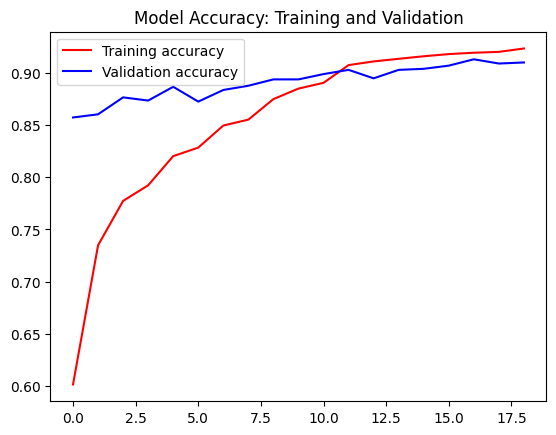

<Figure size 640x480 with 0 Axes>

In [59]:
# Plot training and validation accuracy over epochs
plt.plot(epochsl32, accl32, 'r', label='Training accuracy')
plt.plot(epochsl32, val_accl32, 'b', label='Validation accuracy')
plt.title('Model Accuracy: Training and Validation')
plt.legend(loc=0)
plt.figure()

<Figure size 640x480 with 0 Axes>

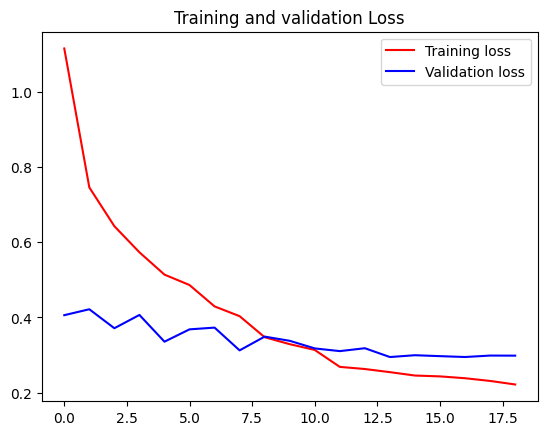

<Figure size 640x480 with 0 Axes>

In [60]:
# Plot training and validation loss over epochs
plt.plot(epochsl32, lossl32, 'r', label='Training loss')
plt.plot(epochsl32, val_lossl32, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

In [61]:
# Evaluate the performance of the ViT-L32 model on the test set
model_test_performace_l32 = model_l32.evaluate(test_batches)

# Print the test accuracy
test_accuracy_l32 = model_test_performace_l32[1]
print(f'Test accuracy: {round(test_accuracy_l32*100, 2)}%')

985/985 [==============================] - 51s 52ms/step - loss: 0.2952 - accuracy: 0.9157
Test accuracy: 91.57%


In [62]:
# Generate predictions for the test set using the ViT-L16 model
predictions_l32 = model_l32.predict(test_batches, steps=len(test_batches), verbose=1)

985/985 [==============================] - 57s 52ms/step


### Confusion Matrix

Confusion matrix, without normalization
[[ 15   2   1   1   5   3   0]
 [  0  27   0   0   1   4   0]
 [  0   1  41   0  10  26   0]
 [  0   0   0   6   0   1   0]
 [  0   1   0   1  24  14   1]
 [  1   0   2   0   6 779   0]
 [  0   0   0   0   0   2  10]]


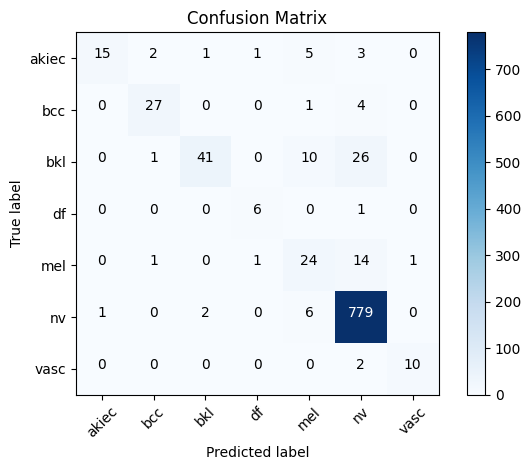

In [63]:
# Create a confusion matrix using true class labels and predicted class indices
cml32 = confusion_matrix(test_labels, predictions_l32.argmax(axis=1))

# Plot the confusion matrix
plot_confusion_matrix(cml32, cm_plot_labels, title='Confusion Matrix')

### Recall Melanoma

In [64]:
# Use argmax to get the predicted labels directly from the probabilities
predicted_labels_mell32 = np.argmax(predictions_l32, axis=1)

# Calculate Recall for the Melanoma class
recall_mell32 = recall_score(test_labels, predicted_labels_mell32, labels=[class_index], average=None)
rounded_recall_mell32 = np.round(recall_mell32, 4)*100

print(f"Recall for Melanoma class: {rounded_recall_mell32[0]:.2f}%")

Recall for Melanoma class: 58.54%


## Base Models

In [65]:
# Set your directory path
data_dir = '/content'

# Load dataset
metadata = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join(data_dir, '*', '*.jpg'))}

# Preprocess the data
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    #img = img.astype('float32') / 255
    return img

# Prepare images and labels
images = np.array([preprocess_image(image_path[idx]) for idx in metadata['image_id']])
labels = pd.get_dummies(metadata['dx']).values

# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalization as pixel values range from 0 to 255
x_train = x_train/255.0
x_test = x_test/255.0

# Reshape the array (4d to 2d)
nsamples, nx, ny, nrgb = x_train.shape
x_train2 = x_train.reshape((nsamples,nx*ny*nrgb))
nsamples, nx, ny, nrgb = x_test.shape
x_test2 = x_test.reshape((nsamples,nx*ny*nrgb))

### Decision Tree Classifier

In [66]:
model_dtc=DecisionTreeClassifier()
model_dtc.fit(x_train2,y_train)

# Compute accuracy
y_pred_dtc= model_dtc.predict(x_test2)
acc_dtc = accuracy_score(y_pred_dtc,y_test)
print(f'Test accuracy for Decision Tree Classifier: {round(acc_dtc*100, 2)}%')

# Compute recall for Melanoma (Class = 4)
recall_mel_dtc = recall_score(y_test, y_pred_dtc, labels=[class_index], average=None)
rounded_recall_mel_dtc = np.round(recall_mel_dtc, 4)*100
print(f"Recall for Melanoma class: {rounded_recall_mel_dtc[0]:.2f}%")

Test accuracy for Decision Tree Classifier: 61.06%
Recall for Melanoma class: 24.78%


### K-Nearest Neighbors Classifier

In [67]:
model_knn = KNeighborsClassifier()
model_knn.fit(x_train2, y_train)

# Compute accuracy
y_pred_knn = model_knn.predict(x_test2)
acc_knn = accuracy_score(y_pred_knn, y_test)
print(f'Test accuracy for K-Nearest Neighbors Classifier: {round(acc_knn * 100, 2)}%')

# Compute recall for Melanoma (Class = 4)
recall_mel_knn = recall_score(y_test, y_pred_knn, labels=[class_index], average=None)
rounded_recall_mel_knn = np.round(recall_mel_knn, 4)*100
print(f"Recall for Melanoma class: {rounded_recall_mel_knn[0]:.2f}%")

Test accuracy for K-Nearest Neighbors Classifier: 65.45%
Recall for Melanoma class: 6.19%
